# Etsy Pricing Model

Here is a brief description of the project / model.

**Name** &nbsp; Rebecca Neel

**Date** &nbsp; 11 July, 2023 -

## Import Packages

In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandasql import sqldf
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Set a seed for random state.

In [142]:
seed = 92308

## Proof of Concept Baseline Model

The following data was scraped from Etsy between July 7 and July 11, 2023. (See [this notebook](web-scraping.ipynb) for more details.)

In [67]:
df = pd.read_csv('Data/proof_of_concept_model.csv', index_col=0)
df.head()

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description,...,later_days_to_arrival,current_date,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
index,,,,,,,,,,,,,,,,,,,,,
29337,School start PDF template candle tattoo candle...,https://www.etsy.com/listing/1438910230/school...,Brand,HellooAnni,2.4,USD,10,4.9766,1363.0,This product is a downloadable digital file :)...,...,NaN,2023-07-11,HellooAnni,Lovingly Made Clothes & Accessories <3<3,"Emsdetten, Germany",7869.0,872.0,5.0,1375.0,2020.0
144399,"Endless Summer, Soy Candle, Jar Candles, Wood ...",https://www.etsy.com/listing/1144400794/endles...,Brand,ChineshasCloset,16.0,USD,16,4.9691,2420.0,Berry sorbet with light hints of summer flower...,...,17 days 00:00:00,2023-07-11,ChineshasCloset,AWAKEN YOUR SENSES WITH AROMATIC SCENTED CANDL...,"Nashville, Tennessee",8276.0,1172.0,5.0,2420.0,2017.0
147618,Mystery Item from our wonky or Overstock Shelf...,https://www.etsy.com/listing/1075221942/myster...,Brand,TeresaLynnsSimpleLux,12.0,USD,19,4.9475,25699.0,We literally don&#39;t even know what you are ...,...,7 days 00:00:00,2023-07-11,TeresaLynnsSimpleLux,Pure Soy Wax Wooden Wick Candles and Skin Care,"Monrovia, Indiana",87673.0,10218.0,5.0,25723.0,2013.0
16123,Light Teal Turquoise Rustic Unscented Pillar C...,https://www.etsy.com/listing/198199650/light-t...,Brand,StillWaterCandles,16.0,USD,44,4.9282,3750.0,This large light teal unscented rustic pillar ...,...,9 days 00:00:00,2023-07-11,StillWaterCandles,Handmade Rustic Pillar Candles - Free Ship ov...,"Missouri, United States",20080.0,3958.0,5.0,3752.0,2011.0
7595,Fall Candle / Pure Soy / Autumn Candle / Fall ...,https://www.etsy.com/listing/251445692/fall-ca...,Brand,TheDancingWick,15.0,USD,12,4.9323,29144.0,These candles are my version of the white pump...,...,10 days 00:00:00,2023-07-11,TheDancingWick,"Personalized Soy Candles, Favors & Sugar scrubs","Bixby, Oklahoma",150866.0,21155.0,5.0,29173.0,2011.0


Check null values.

In [6]:
df.isna().sum()

product_name                     0
product_url                      0
brand_type                       0
brand_name                       0
price                            0
currency                         0
position                         0
avg_rating                     274
review_count                   274
product_description              0
seller_response_time          1359
return_and_exchange_policy     159
item_listing_date              145
item_favorites                 305
early_est_arrival              469
later_est_arrival              469
early_days_to_arrival          469
later_days_to_arrival          469
current_date                     0
name                             0
shop_description                 0
location                         1
num_sales                        0
num_admirers                     0
avg_item_review_rounded        272
num_item_reviews               272
on_etsy_since                    0
dtype: int64

Strategy:

For brands with null review count and on_etsy_since = current year, set review count to 0.
Then impute the remaining records with the mean review count (these sellers just haven't had a review in the last year.) Treat avg_item_review_rounded and num_item_reviews similarly.

Impute average rating with the mean.

Impute seller response time with the mean. Consider also adding a signal column for this feature.

Treat return & exchange policy as a categorical variable - null can be treated as a category (no policy listed.)

Create a new feature from item listing date (days since listed.) Then impute missing values with the mean.

Replace null values for item_favorites with 0. (If not listed on the page, no one has favorited the item, presumably. Etsy does not report "0 item favorites.")

Impute early and late days to arrival with the mean.

Fill in "no_response_time_given" for seller response time categories, and change names.

Do not include location in baseline model, but could treat as a categorical variable later by classifying to regions (e.g. northeast United States, eastern Europe, etc.)

Ultimately, do not include the following columns in the baseline model:
- product name *
- product url
- brand type (all the same)
- brand name *
- price (this is the target)
- currency (all the same)
- position
- product description *
- item listing date (use days since listed instead)
- early estimated arrival
- later estimated arrival
- current date
- name (this is the name of the brand, from the brand data dataframe)
- shop description *
- location **

\* These features are NLP features that could be included later.

\** Location could be included later after mapping to broader categories (see above.)

For brands with null review count and on_etsy_since = current year, set review count to 0. We will assume that these sellers have not received any reviews yet.

In [68]:
df.loc[(df.review_count.isna())&(df.on_etsy_since==2023), 'review_count'] = 0

Other sellers with a null review count likely have not received any reviews in the past year, or their shop has gone inactive since we scraped the initial product data. We will impute these missing values with the mean.

In [16]:
from sklearn.impute import SimpleImputer

si = SimpleImputer()

To be imputed (with the mean):

avg_rating, avg_item_review_rounded

review_count, num_item_reviews

Repeat the above steps for avg_item_review and num_item_reviews.

In [69]:
df.loc[(df.num_item_reviews.isna())&(df.on_etsy_since==2023), 'num_item_reviews'] = 0

Return and exchange policy can be categorized into: "not accepted", "free", "cost", "date-restricted", and "not listed".

Replace null values with the string "Not listed."

In [70]:
df.loc[df.return_and_exchange_policy.isna(), 'return_and_exchange_policy'] = "Not listed"

Map return and exchange policies to return and exchange policy categories.

In [71]:
# all costs start with $; date restricted start with "J" or "A" for Jul or Aug
df['return_and_exchange_policy_category'] = df.return_and_exchange_policy.map(lambda x: x[0])

In [72]:
df.loc[df.return_and_exchange_policy_category == 'J', 'return_and_exchange_policy_category'] = 'date_restricted'

In [73]:
df.loc[df.return_and_exchange_policy_category == 'A', 'return_and_exchange_policy_category'] = 'date_restricted'

In [74]:
df.loc[df.return_and_exchange_policy_category == '$', 'return_and_exchange_policy_category'] = 'cost'

In [75]:
df.loc[df.return_and_exchange_policy == 'Not accepted', 'return_and_exchange_policy_category'] = 'not_accepted'

In [76]:
df.loc[df.return_and_exchange_policy == 'Free', 'return_and_exchange_policy_category'] = 'free'

In [77]:
df.loc[df.return_and_exchange_policy == 'Not listed', 'return_and_exchange_policy_category'] = 'not_listed'

In [78]:
df.return_and_exchange_policy_category.value_counts()

not_accepted       2592
date_restricted    1326
cost               1316
free                647
not_listed          159
Name: return_and_exchange_policy_category, dtype: int64

Get days since listing was first posted.

In [79]:
df['days_since_listed'] = pd.to_datetime(df.current_date) - pd.to_datetime(df.item_listing_date)

Impute the above column with the mean.

Replace null values for "item_favorites" with 0. (This information is not displayed if an item has not been favorited by anyone, so it is null after scraping.)

In [80]:
df.loc[df.item_favorites.isna(), 'item_favorites'] = 0

Impute early and later days to arrival with the mean.

Re-word categories for seller response time.

In [81]:
df.seller_response_time.value_counts()

This seller usually responds within a few hours.    3138
This seller usually responds within 24 hours.       1543
Name: seller_response_time, dtype: int64

In [82]:
df.seller_response_time = \
df.seller_response_time.replace({'This seller usually responds within a few hours.': 'within_a_few_hours',
                                 'This seller usually responds within 24 hours.': 'within_24_hours',
                                 None: 'none_given'})

In [83]:
df.seller_response_time.value_counts()

within_a_few_hours    3138
within_24_hours       1543
none_given            1359
Name: seller_response_time, dtype: int64

Convert datetime objects to float, to avoid issues imputing the mean.

For early days to arrival and later days to arrival, give the number of days as an integer for all non-null values.

In [167]:
df.loc[~df.early_days_to_arrival.isna(), 'early_days_to_arrival'] = \
df.early_days_to_arrival.dropna().map(lambda x: int(' '.join(x.split()[:1])))

In [172]:
df.loc[~df.later_days_to_arrival.isna(), 'later_days_to_arrival'] = \
df.later_days_to_arrival.dropna().map(lambda x: int(' '.join(x.split()[:1])))

In [175]:
df.early_days_to_arrival = df.early_days_to_arrival.astype(float)
df.later_days_to_arrival = df.later_days_to_arrival.astype(float)

Give the number of days since an item was listed as a float.

In [185]:
df.loc[~(df.days_since_listed.isna()), 'days_since_listed'] = \
df.days_since_listed.dropna().map(lambda x: int(str(x).split()[0]))

In [199]:
df.loc[df.days_since_listed.map(lambda x: str(x)) == 'NaT', 'days_since_listed'] = None

In [201]:
df.days_since_listed = df.days_since_listed.astype(float)

## Correlation

Check for correlations between numerical features, and correlations of numerical features with the target.

/var/folders/n1/06kwj40j2q1g58ss6ym4_57h0000gn/T/ipykernel_16087/488310907.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt='.2g', cmap='coolwarm');


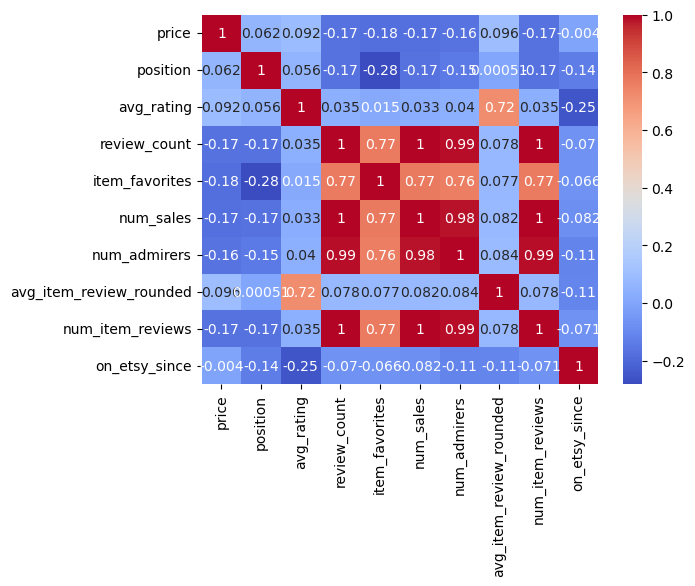

In [95]:
sns.heatmap(df.corr(), annot=True, fmt='.2g', cmap='coolwarm');

The heatmap will be easier to read if we remove the diagonal and lower "triangle" of the matrix (to avoid extraneous and repetitive information, respectively.)

In [99]:
upperMatrix = df.corr().where(np.triu(np.ones(df.corr().shape), k=1).astype(bool))

/var/folders/n1/06kwj40j2q1g58ss6ym4_57h0000gn/T/ipykernel_16087/274361138.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  upperMatrix = df.corr().where(np.triu(np.ones(df.corr().shape), k=1).astype(bool))


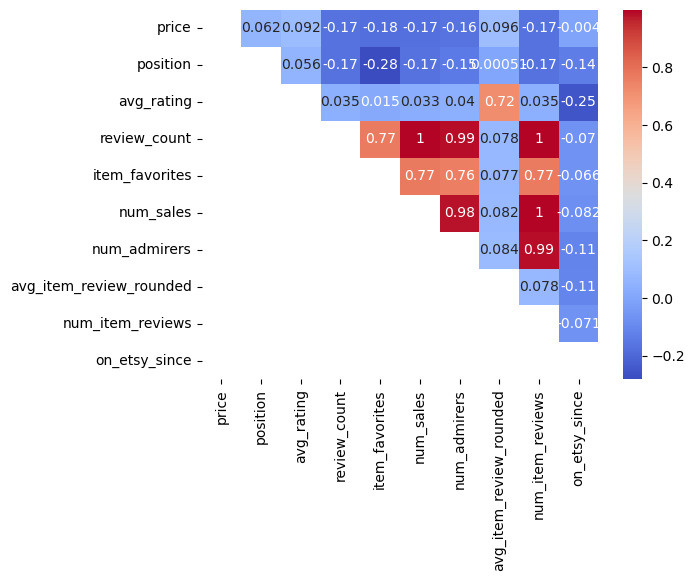

In [102]:
sns.heatmap(upperMatrix, annot=True, fmt='.2g', cmap='coolwarm');

Review count is strongly correlated with number of sales, number of admirers and number of item reviews.

The number of favorites that an item has is also strongly correlated to the above four features, although substantially less so.

Unfortunately, very few numerical features in the dataset have a strong correlation to price. :(

## Distribution of Target

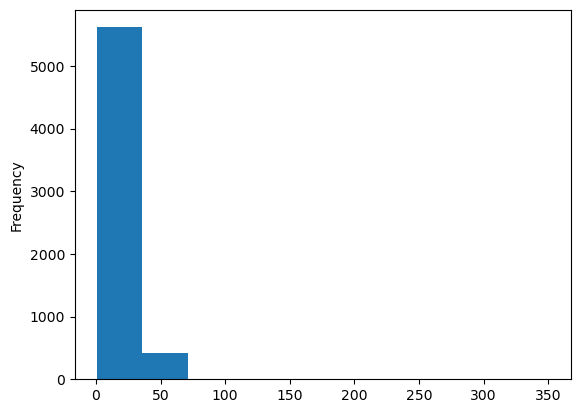

In [104]:
df['price'].plot(kind='hist');

/Users/user/opt/anaconda3/envs/etsy-demand-model/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


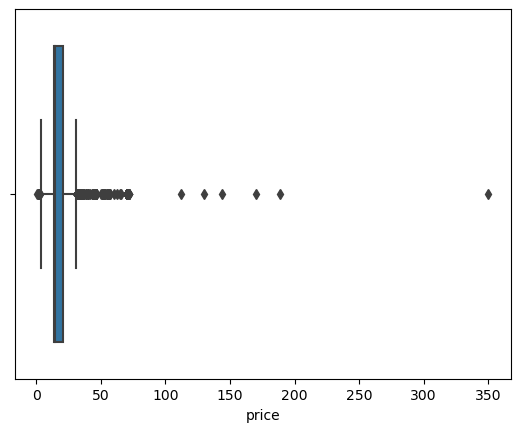

In [105]:
sns.boxplot(df['price']);

In [106]:
df['price'].describe()

count    6040.000000
mean       19.505818
std        12.828481
min         1.020000
25%        13.990000
50%        15.000000
75%        20.990000
max       350.000000
Name: price, dtype: float64

Most candles are priced within a very narrow range. It might be beneficial to remove outliers before modeling.

How does response time affect price?

Response time: none_given
Average (mean) price: 17.6
Standard deviation: 12.58


Response time: within_24_hours
Average (mean) price: 24.42
Standard deviation: 15.69


Response time: within_a_few_hours
Average (mean) price: 17.92
Standard deviation: 10.54




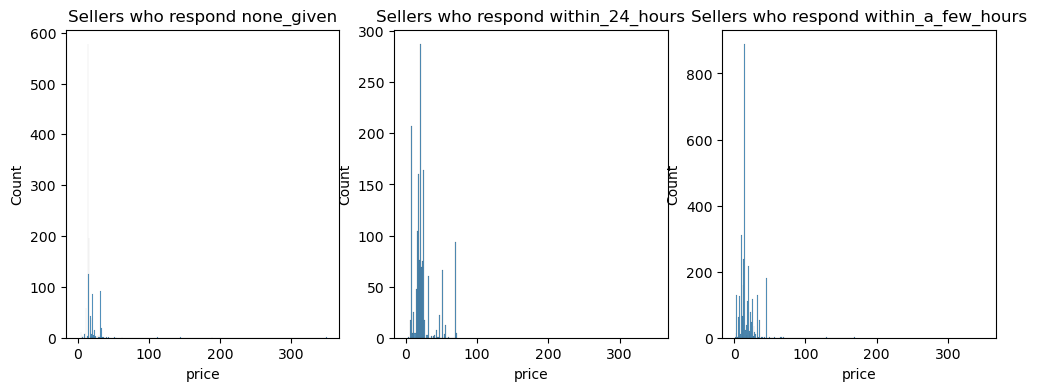

In [122]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4), sharex=True)
i=0

for response_time in np.unique(df.seller_response_time):

    print(f'Response time: {response_time}')
    print(f"Average (mean) price: {round(np.mean(df.loc[df.seller_response_time==response_time, 'price']), 2)}")
    print(f"Standard deviation: {round(np.std(df.loc[df.seller_response_time==response_time, 'price']), 2)}")
    sns.histplot(df.loc[df.seller_response_time==response_time, 'price'], ax=ax[i])
    ax[i].set_title(f'Sellers who respond {response_time}');
    i+=1
    print('\n')

Not particularly insightful.

How does a listed return and exchange policy affect price?

Response time: within_a_few_hours
Average (mean) price: 16.68
Standard deviation: 6.52


Response time: within_a_few_hours
Average (mean) price: 17.43
Standard deviation: 8.45


Response time: within_a_few_hours
Average (mean) price: 20.35
Standard deviation: 14.63


Response time: within_a_few_hours
Average (mean) price: 21.18
Standard deviation: 13.85


Response time: within_a_few_hours
Average (mean) price: 29.52
Standard deviation: 32.49




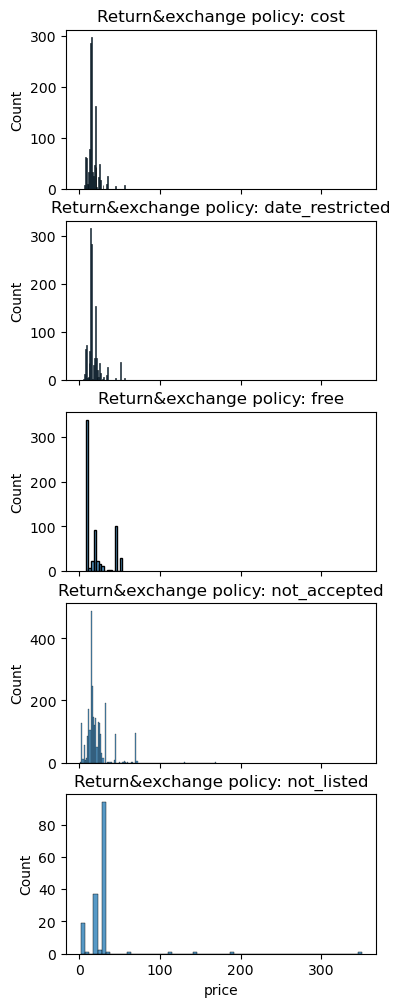

In [124]:
fig, ax = plt.subplots(nrows=5, figsize=(4, 12), sharex=True)
i=0

for policy in np.unique(df.return_and_exchange_policy_category):

    print(f'Response time: {response_time}')
    print(f"Average (mean) price: {round(np.mean(df.loc[df.return_and_exchange_policy_category==policy, 'price']), 2)}")
    print(f"Standard deviation: {round(np.std(df.loc[df.return_and_exchange_policy_category==policy, 'price']), 2)}")
    sns.histplot(df.loc[df.return_and_exchange_policy_category==policy, 'price'], ax=ax[i])
    ax[i].set_title(f'Return&exchange policy: {policy}');
    i+=1
    print('\n')

## Remove Outliers

for price

Standard formula:

Compute IQR.

Compute minimum value: Q1 - 1.5\*IQR

Compute maximum value: Q3 + 1.5\*IQR

Find and inspect records which are outliers (price < minimum value) | (price > maximum value).

Remove those records from dataframe.

In [128]:
price_IQR = df.price.quantile(0.75) - df.price.quantile(0.25)
price_IQR

6.999999999999998

In [129]:
price_min_acceptable_value = df.price.quantile(0.25) - 1.5*price_IQR
price_min_acceptable_value

3.4900000000000038

In [131]:
price_max_acceptable_value = df.price.quantile(.75) + 1.5*price_IQR
price_max_acceptable_value

31.489999999999995

In [137]:
# find outliers
df.loc[(df.price < price_min_acceptable_value) | (df.price > price_max_acceptable_value)]

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description,...,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since,return_and_exchange_policy_category,days_since_listed
index,,,,,,,,,,,,,,,,,,,,,
29337,School start PDF template candle tattoo candle...,https://www.etsy.com/listing/1438910230/school...,Brand,HellooAnni,2.40,USD,10,4.9766,1363.0,This product is a downloadable digital file :)...,...,HellooAnni,Lovingly Made Clothes & Accessories <3<3,"Emsdetten, Germany",7869.0,872.0,5.0,1375.0,2020.0,not_listed,2 days
94936,"Personalized Friend Gift, Gift For Her, Friend...",https://www.etsy.com/listing/562718695/persona...,Brand,TheShabbyWick,33.00,USD,41,4.9313,5385.0,Personalized Friend Gift Gift For Her Friend B...,...,TheShabbyWick,A Candle For Every Moment,"Dripping Springs, Texas",26354.0,3173.0,5.0,5387.0,2016.0,not_accepted,3 days
156692,One Dozen 6&quot; Tall Hand Rolled Pure Beeswa...,https://www.etsy.com/listing/483834821/one-doz...,Brand,BearCreekCandleCo,34.00,USD,21,4.9348,110.0,Our lovely beeswax honeycomb taper candles are...,...,BearCreekCandleCo,Pure Beeswax Honeycomb Candles. Hand-made in A...,"Asheville, North Carolina",451.0,109.0,5.0,110.0,2014.0,date_restricted,2 days
28027,A Personalised Steel Love Heart T Light~ 11th ...,https://www.etsy.com/listing/552227465/a-perso...,Brand,JonsCountryIronwork,56.22,USD,44,4.9211,1660.0,A Single &#39;Personalised Heart&#39; Steel T ...,...,JonsCountryIronwork,Jons Country Ironwork,Isle of Man,13929.0,1256.0,5.0,1667.0,2014.0,cost,2 days
14913,"Personalized Friend Gift, Gift For Her, Friend...",https://www.etsy.com/listing/562718695/persona...,Brand,TheShabbyWick,33.00,USD,34,4.9313,5385.0,Personalized Friend Gift Gift For Her Friend B...,...,TheShabbyWick,A Candle For Every Moment,"Dripping Springs, Texas",26354.0,3173.0,5.0,5387.0,2016.0,not_accepted,3 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151168,One Dozen 6&quot; Tall Hand Rolled Pure Beeswa...,https://www.etsy.com/listing/483834821/one-doz...,Brand,BearCreekCandleCo,34.00,USD,17,4.9348,110.0,Our lovely beeswax honeycomb taper candles are...,...,BearCreekCandleCo,Pure Beeswax Honeycomb Candles. Hand-made in A...,"Asheville, North Carolina",451.0,109.0,5.0,110.0,2014.0,cost,2 days
44137,beeswax Hanukkah Menorah candle - Hanukkah can...,https://www.etsy.com/listing/260343047/beeswax...,Brand,MileEndSoapandCandle,35.34,USD,26,4.9574,417.0,Hanukkah candles and menorah all in one!\n\nCe...,...,MileEndSoapandCandle,Botanical soap and pure beeswax candles,"Montreal, Canada",2023.0,1069.0,5.0,417.0,2009.0,cost,77 days
121986,"Unscented Soy Tealights 100 Pack, Handmade, No...",https://www.etsy.com/listing/76662115/unscente...,Brand,southernmadecandle,45.90,USD,19,4.9855,1720.0,Unscented (no fragrance oil added) Soy Clear P...,...,southernmadecandle,Southern Made Candles LLC,"Weaverville, North Carolina",4825.0,758.0,5.0,1720.0,2011.0,free,6 days


I don't love the idea of losing hundreds of candles, some of which are barely over the maximum acceptable price according to the standard formula for computing outliers (and which I definitely don't personally think are overpriced.)

Instead of using the formula to determine an "upper bound" on acceptable price for a candle, I am going to implement \\$100 as the maximum acceptable price.

In [138]:
price_max_acceptable_value = 100

## Train Test Split

Remove outliers.

In [203]:
df_no_outliers = df.loc[(df.price > price_min_acceptable_value) & (df.price < price_max_acceptable_value)]

Drop columns not needed for modeling.

In [204]:
X = df_no_outliers.drop(columns=['product_name', 'product_url', 'brand_type', 'brand_name', 'price', 'currency',
                                 'position', 'product_description', 'return_and_exchange_policy', 'item_listing_date',
                                 'early_est_arrival', 'later_est_arrival', 'current_date', 'name', 'shop_description',
                                 'location']
                       )
y = df_no_outliers['price'].copy()

X.head()

,avg_rating,review_count,seller_response_time,item_favorites,early_days_to_arrival,later_days_to_arrival,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since,return_and_exchange_policy_category,days_since_listed
index,,,,,,,,,,,,,
144399,4.9691,2420.0,within_a_few_hours,2.0,11.0,17.0,8276.0,1172.0,5.0,2420.0,2017.0,not_accepted,2.0
147618,4.9475,25699.0,within_a_few_hours,1307.0,2.0,7.0,87673.0,10218.0,5.0,25723.0,2013.0,date_restricted,0.0
16123,4.9282,3750.0,none_given,762.0,8.0,9.0,20080.0,3958.0,5.0,3752.0,2011.0,not_accepted,0.0
7595,4.9323,29144.0,within_a_few_hours,17705.0,2.0,10.0,150866.0,21155.0,5.0,29173.0,2011.0,date_restricted,0.0
182537,4.9524,24133.0,within_24_hours,569.0,2.0,10.0,76266.0,17753.0,5.0,24136.0,2010.0,date_restricted,36.0


Train test split.

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [206]:
print(X_train.shape)
print(y_train.shape)

(4815, 13)
(4815,)


## Preprocess Data for Modeling

Instantiate a one hot encoder and simple imputer. Use a column transformer to apply each one to the appropriate columns. Then scale all of the data with a standard scaler.

In [259]:
ohe = OneHotEncoder(drop='first')
si = SimpleImputer()

categorical_features = ['seller_response_time', 'return_and_exchange_policy_category']

numeric_features = ['avg_rating', 'review_count', 'early_days_to_arrival', 'later_days_to_arrival',
                  'avg_item_review_rounded', 'num_item_reviews', 'days_since_listed']

preprocessor = ColumnTransformer(
    transformers=[
        ("num", si, numeric_features),
        ("cat", ohe, categorical_features),
    ],
    remainder='passthrough' # keep other features
)

ss = StandardScaler()

X_train_preprocessed = pd.DataFrame(ss.fit_transform(preprocessor.fit_transform(X_train)),
                                    columns=preprocessor.get_feature_names_out(),
                                    index=X_train.index)
X_test_preprocessed = pd.DataFrame(ss.transform(preprocessor.transform(X_test)),
                                   columns=preprocessor.get_feature_names_out(),
                                   index=X_test.index)

X_train_preprocessed.head()

,num__avg_rating,num__review_count,num__early_days_to_arrival,num__later_days_to_arrival,num__avg_item_review_rounded,num__num_item_reviews,num__days_since_listed,cat__seller_response_time_within_24_hours,cat__seller_response_time_within_a_few_hours,cat__return_and_exchange_policy_category_date_restricted,cat__return_and_exchange_policy_category_free,cat__return_and_exchange_policy_category_not_accepted,cat__return_and_exchange_policy_category_not_listed,remainder__item_favorites,remainder__num_sales,remainder__num_admirers,remainder__on_etsy_since
index,,,,,,,,,,,,,,,,,
162739,0.068165,4.130193,-0.637577,-0.956764,0.213763,4.128933,-0.591078,-0.596621,0.978426,-0.524878,2.889553,-0.878735,-0.158501,2.375068,4.092112,4.064413,-0.070779
163673,0.251380,0.379596,-0.637577,-0.303214,0.213763,0.379427,-0.495472,-0.596621,0.978426,-0.524878,-0.346074,-0.878735,-0.158501,-0.273701,0.541450,0.304473,-1.038053
179954,-1.064439,-0.378166,-0.637577,-0.629989,0.213763,-0.378096,-0.543275,1.676107,-1.022050,-0.524878,-0.346074,1.138000,-0.158501,-0.282067,-0.377082,-0.392371,0.896494
14828,0.807966,-0.315216,-0.637577,-0.956764,0.213763,-0.315105,-0.495472,-0.596621,0.978426,1.905205,-0.346074,-0.878735,-0.158501,-0.161189,-0.302125,-0.220050,0.251645
168688,-0.228866,-0.296644,-0.637577,-1.283540,0.213763,-0.296626,0.173772,-0.596621,-1.022050,-0.524878,-0.346074,-0.878735,-0.158501,-0.252847,-0.295835,-0.283354,0.574070


## Baseline Model

In [280]:
lr = LinearRegression()

lr.fit(X_train_preprocessed, y_train)

print(f'RMSE on Training Data: {np.sqrt(mean_squared_error(y_train, lr.predict(X_train_preprocessed)))}')

print(f'RMSE on Test Data: {np.sqrt(mean_squared_error(y_test, lr.predict(X_test_preprocessed)))}')

RMSE on Training Data: 10.424423506741952
RMSE on Test Data: 9.753327969372958


In [281]:
lr.score(X_test_preprocessed, y_test)

0.20372484238256838

To compare, here is the root mean squared error for a model which predicts the mean.

In [279]:
np.sqrt(mean_squared_error(df_no_outliers.price, df_no_outliers.price.mean()*np.ones(df_no_outliers.price.shape)))

11.474472207650944

Here is the standard deviation of the difference between the model's predictions and the actual prices, for the test set.

In [264]:
np.sqrt(np.sum((lr.predict(X_test_preprocessed) - y_test)**2))

338.42783189285126

So we could interpret this loosely as, an average prediction for the price is \\$338.43 above the actual price. This scale of error is not appropriate for the problem at hand - we may need to abandon the project or take a different tact.

Residual plot:

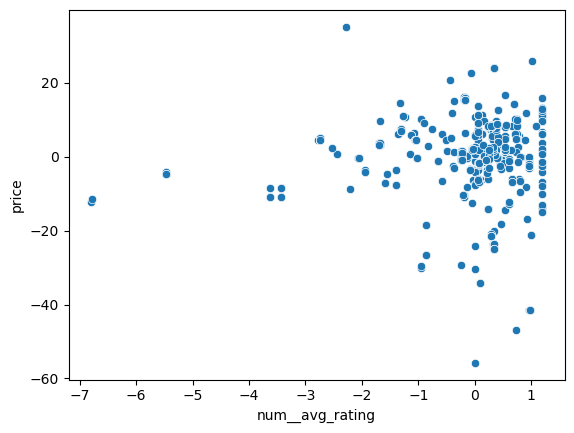

In [270]:
test_residuals = (lr.predict(X_test_preprocessed) - y_test)

fig, ax = plt.subplots()

sns.scatterplot(x=X_test_preprocessed.num__avg_rating, y=test_residuals);

Build a "baseline" model with only one feature: item_favorites (the most strongly negatively correlated feature with price.)

RMSE:

In [275]:
lr.fit(np.array(X_train_preprocessed.remainder__item_favorites).reshape(-1,1), y_train)

np.sqrt(np.sum((lr.predict(np.array(X_test_preprocessed.remainder__item_favorites).reshape(-1,1)) - y_test)**2))

370.6468842561869

Residual plot:

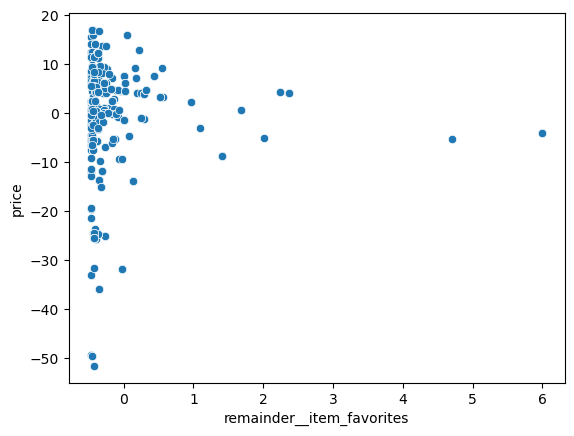

In [278]:
test_residuals = (lr.predict(np.array(X_test_preprocessed.remainder__item_favorites).reshape(-1,1)) - y_test)

fig, ax = plt.subplots()

sns.scatterplot(x=X_test_preprocessed.remainder__item_favorites, y=test_residuals);

## Load Data

Blurb about loading data. (Look at [this notebook](web-scraping.ipynb) to see script used to scrape the below data from July 7 - 10, 2023.)

In [3]:
data = pd.read_csv('Data/product_data.csv')
data.head()

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description
0,Yellow Gold Rustic Unscented Pillar Candle - C...,https://www.etsy.com/listing/171033085/yellow-...,Brand,StillWaterCandles,16.0,USD,1,4.9284,3750.0,This large yellow gold rustic unscented pillar...
1,Pear Green Rustic Textured Unscented Block Pil...,https://www.etsy.com/listing/98864574/pear-gre...,Brand,StillWaterCandles,16.0,USD,2,4.9284,3750.0,This large pear green rustic unscented pillar ...
2,Burnt Orange Rustic Large Unscented Pillar Can...,https://www.etsy.com/listing/172053498/burnt-o...,Brand,StillWaterCandles,16.0,USD,3,4.9284,3750.0,This large burnt orange unscented rustic pilla...
3,Soy Mason Jar Candle////Choose Your Scent//Con...,https://www.etsy.com/listing/270002845/soy-mas...,Brand,TheDancingWick,15.0,USD,4,4.9323,29140.0,These beautiful candles are the perfect additi...
4,Rainbow Candle / Soy Candle with 6 colorful la...,https://www.etsy.com/listing/251774155/rainbow...,Brand,SoapForYourSoul,29.0,USD,5,4.9102,5057.0,Colorful rainbow candle is six layers of scent...


**TO DO **
- [ ] Add brand info.
- [ ] Drop records based on missing brand info.
- [ ] Feature engineering round 1 (number of other candles for sale, etc.)
- [ ] Get a random sample of 10,000 candles.
- [ ] Fix the review_count for candles in sample (get number of review for individual product, as well as for brand as a whole.) Can you also get the earliest and latest estimated arrival, in days from now? And whether or not returns and exchanges are accepted? And the listing date? And the number of favorites?

We have information about 190,128 candles that were for sale on Etsy from July 7-10 in 2023.

In [4]:
print(data.shape)

(190128, 10)


Add newly scraped information about the brand.

In [25]:
brand_data = pd.read_csv('Data/brand_data_raw.csv', index_col=0)
brand_data.head()

,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
0,160candles,Hand-poured candles – with 100% soy wax and 0%...,Europe,68.0,50.0,5.0,21.0,2021.0
1,16wishescandles,Everything SWEET 16 for your MAGICAL day- xoxo,"Dallas, Texas",1533.0,363.0,4.0,280.0,NaN
2,Sunnysmilenyc,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,27thcandle,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,320Sycamorecandles,Hand Poured Pure Soy Candles with Cotton Wicks,"Overland, Missouri",6700.0,1009.0,5.0,1715.0,2016.0


Check null values in brand data.

In [31]:
brand_data.isna().sum()

name                         1
shop_description           284
location                   144
num_sales                   30
num_admirers                30
avg_item_review_rounded    436
num_item_reviews           436
on_etsy_since              648
dtype: int64

Drop records with a null value for num_sales or name.

In [34]:
brand_data.dropna(subset=['name', 'num_sales'], axis=0, inplace=True)

Join brand_data to product_data.

In [42]:
query = '''SELECT *
           FROM data
           LEFT JOIN brand_data
           ON data.brand_name = brand_data.name'''

all_data = sqldf(query)

all_data.head()

,product_name,product_url,brand_type,brand_name,price,currency,position,avg_rating,review_count,product_description,name,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
0,Yellow Gold Rustic Unscented Pillar Candle - C...,https://www.etsy.com/listing/171033085/yellow-...,Brand,StillWaterCandles,16.0,USD,1,4.9284,3750.0,This large yellow gold rustic unscented pillar...,StillWaterCandles,Handmade Rustic Pillar Candles - Free Ship ov...,"Missouri, United States",20080.0,3958.0,5.0,3752.0,2011.0
1,Pear Green Rustic Textured Unscented Block Pil...,https://www.etsy.com/listing/98864574/pear-gre...,Brand,StillWaterCandles,16.0,USD,2,4.9284,3750.0,This large pear green rustic unscented pillar ...,StillWaterCandles,Handmade Rustic Pillar Candles - Free Ship ov...,"Missouri, United States",20080.0,3958.0,5.0,3752.0,2011.0
2,Burnt Orange Rustic Large Unscented Pillar Can...,https://www.etsy.com/listing/172053498/burnt-o...,Brand,StillWaterCandles,16.0,USD,3,4.9284,3750.0,This large burnt orange unscented rustic pilla...,StillWaterCandles,Handmade Rustic Pillar Candles - Free Ship ov...,"Missouri, United States",20080.0,3958.0,5.0,3752.0,2011.0
3,Soy Mason Jar Candle////Choose Your Scent//Con...,https://www.etsy.com/listing/270002845/soy-mas...,Brand,TheDancingWick,15.0,USD,4,4.9323,29140.0,These beautiful candles are the perfect additi...,TheDancingWick,"Personalized Soy Candles, Favors & Sugar scrubs","Bixby, Oklahoma",150866.0,21155.0,5.0,29173.0,2011.0
4,Rainbow Candle / Soy Candle with 6 colorful la...,https://www.etsy.com/listing/251774155/rainbow...,Brand,SoapForYourSoul,29.0,USD,5,4.9102,5057.0,Colorful rainbow candle is six layers of scent...,SoapForYourSoul,"Handmade Soap Company, Soy Candles & Laundry Soap","Conway, South Carolina",13650.0,11583.0,5.0,5060.0,2009.0


We don't need a "brand_name" and a "name" column. Also, "brand_type" is Brand for every record, so we can drop this feature. We also don't need product_url anymore.

In [43]:
all_data.drop(columns=['brand_type', 'name', 'product_url'], inplace=True)

Below are the current counts for all null values in each feature category.

In [44]:
all_data.isna().sum()

product_name                  14
brand_name                     0
price                         19
currency                      19
position                       0
avg_rating                 11330
review_count               11330
product_description           24
shop_description            5242
location                    1689
num_sales                    417
num_admirers                 417
avg_item_review_rounded    11332
num_item_reviews           11332
on_etsy_since              17875
dtype: int64

In [46]:
query = '''SELECT *
           FROM (
                 SELECT brand_name, count() AS candle_count
                 FROM all_data
                 GROUP BY brand_name
                 ) AS candle_count_table
           RIGHT JOIN all_data
           ON candle_count_table.brand_name = all_data.brand_name
           '''

sqldf(query)

,brand_name,candle_count,product_name,brand_name,price,currency,position,avg_rating,review_count,product_description,shop_description,location,num_sales,num_admirers,avg_item_review_rounded,num_item_reviews,on_etsy_since
0,160candles,3,Birthdate zodiac candle Leo gift birthday astr...,160candles,28.0,USD,9,5.0000,21.0,Birthdate zodiac candle for Leo – perfect astr...,Hand-poured candles – with 100% soy wax and 0%...,Europe,68.0,50.0,5.0,21.0,2021.0
1,160candles,3,Birthdate zodiac candle Leo gift birthday astr...,160candles,28.0,USD,8,5.0000,21.0,Birthdate zodiac candle for Leo – perfect astr...,Hand-poured candles – with 100% soy wax and 0%...,Europe,68.0,50.0,5.0,21.0,2021.0
2,160candles,3,Birthdate zodiac candle Leo gift birthday astr...,160candles,28.0,USD,10,5.0000,21.0,Birthdate zodiac candle for Leo – perfect astr...,Hand-poured candles – with 100% soy wax and 0%...,Europe,68.0,50.0,5.0,21.0,2021.0
3,16wishescandles,6,16 Wishes Candle Box Gold tin Sweet 16 gift id...,16wishescandles,61.0,USD,30,4.6703,280.0,***optional add on**** a replica of Abby Jense...,Everything SWEET 16 for your MAGICAL day- xoxo,"Dallas, Texas",1533.0,363.0,4.0,280.0,NaN
4,16wishescandles,6,16 Wishes Candle Box Gold tin Sweet 16 gift id...,16wishescandles,61.0,USD,29,4.6703,280.0,***optional add on**** a replica of Abby Jense...,Everything SWEET 16 for your MAGICAL day- xoxo,"Dallas, Texas",1533.0,363.0,4.0,280.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190174,yourclassicshop,7,Beyond Beautiful Cherry Blossom Scented Candle...,yourclassicshop,70.0,USD,11,NaN,NaN,Beyond Beautiful Cherry Blossom Scented Candle...,Loris Gift Shop,None,0.0,0.0,NaN,NaN,NaN
190175,yourclassicshop,7,Beyond Beautiful Cherry Blossom Scented Candle...,yourclassicshop,70.0,USD,4,NaN,NaN,Beyond Beautiful Cherry Blossom Scented Candle...,Loris Gift Shop,None,0.0,0.0,NaN,NaN,NaN
190176,yourclassicshop,7,Beyond Beautiful Cherry Blossom Scented Candle...,yourclassicshop,70.0,USD,11,NaN,NaN,Beyond Beautiful Cherry Blossom Scented Candle...,Loris Gift Shop,None,0.0,0.0,NaN,NaN,NaN
190177,yourclassicshop,7,Beyond Beautiful Cherry Blossom Scented Candle...,yourclassicshop,70.0,USD,10,NaN,NaN,Beyond Beautiful Cherry Blossom Scented Candle...,Loris Gift Shop,None,0.0,0.0,NaN,NaN,NaN


In [45]:
all_data.groupby('brand_name').count()['product_name']

brand_name
160candles               3
16wishescandles          6
1995DesignCompany        7
27thcandle               3
320Sycamorecandles      10
                      ... 
withpoesie               4
woodIandwitchcrafts      7
woodwoodhoney            7
www13grammcom          234
yourclassicshop          7
Name: product_name, Length: 1568, dtype: int64

We will use the following features to build a baseline model:

ITEM INFO

- avg_rating
- review_count (for individual product, not brand!)
-

BRAND INFO

- num_sales
- num_admireres
- avg_item_review_rounded
- num_item_reviews
- on_etsy_since

View five number summary for price, average rating and review count.

In [6]:
data.describe().drop(['position'], axis=1)

,price,avg_rating,review_count
count,190109.000000,178849.000000,178849.000000
mean,19.114158,4.915511,14551.489664
std,12.061501,0.081231,37589.173812
min,0.560000,1.000000,1.000000
25%,13.990000,4.901700,1257.000000
50%,15.000000,4.930000,3857.000000
75%,20.950000,4.953900,8205.000000
max,350.000000,5.000000,169122.000000


**Price**

Mean price of a candle: \\$19

Standard deviation: $12

Median price of a candle: \\$15

Maximum price: \\$350

Minimum price: \\$0.56

^^*Explore outliers*

**Average Rating**

Mean mean rating: 4.92

Standard deviation: 0.08

*Most ratings are quite high.*

In fact, 50\% of ratings lie between 4.9 and 4.95.

The minimum, however, is 1, and the maximum is 5, as expected.

**Review Count**

Mean review count: 14,551

Standard deviation: 37,589

Minimum: 1

Maximum: 169,122

50\% lie between 1257 reviews and 8205 reviews.

**Null values**

A little over 11,000 candles do not have an average rating or review count.

19 candles do not have a price listed.

In [8]:
data.avg_rating.isna().sum()

11279

In [9]:
data.price.isna().sum()

19

**Brand**

100% of candles have a brand listed.

In [10]:
data.brand_type.value_counts()

Brand    190128
Name: brand_type, dtype: int64

In [14]:
data.brand_name.isna().sum()

0

Number of brands in the dataset: 1568

In [21]:
data.brand_name.value_counts().shape

(1568,)

50% of brands have between 6 and 19 candles for sale in the search results.

The most prolific brand has 11,211 candles for sale in this dataset alone.

25% of brands have 6 or fewer candles for sale in this dataset.

In [12]:
data.brand_name.value_counts().describe()

count     1568.000000
mean       121.255102
std        703.398801
min          1.000000
25%          6.000000
50%          7.000000
75%         19.000000
max      11211.000000
Name: brand_name, dtype: float64

**Product Description**

24 candles are missing a product description.

In [16]:
data.product_description.isna().sum()

24

The "average" product description contains 452 words, but there is a HUGE standard deviation! In reality, 75% of product descriptions are shorter than 389 words, and 50% have fewer than 233 words.

In [18]:
data.product_description.dropna().map(lambda x: len(x.split())).describe()

count    190104.000000
mean        452.528279
std         892.365711
min           1.000000
25%         146.000000
50%         233.000000
75%         389.000000
max        5602.000000
Name: product_description, dtype: float64

TO DO:

- [ ] Look at top words in product descriptions and product names

**Product Name**

14 candles do not have a product name.

In [19]:
data.product_name.isna().sum()

14

The "average" product name is 16 words long, which is relatively close to the median length as well.

In [20]:
data.product_name.dropna().map(lambda x: len(x.split())).describe()

count    190114.000000
mean         16.107656
std           6.302984
min           1.000000
25%          11.000000
50%          17.000000
75%          22.000000
max          32.000000
Name: product_name, dtype: float64